In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import math
import matplotlib.image as mpimg

In [2]:
#Read the 'readme' file to see what's up
#Pay special attention to the fields and/or columns in each csv file
readme = open("/projects/b1045/AoT/AoT_reduced_data_10m/README.md","r")
print(readme.read())

## NOTE: This README has been modifed by dataReduction.py, and the data included in this directory is now reduced.

Within this README, the 'data.csv.gz' archive is referred to as the compressed CSV containing the sensor data file (data.csv). The data.csv file from this compressed archive has been replaced by the reduced data.csv.
All other metadata mentioned in this README remains the same, except for the provenance metadata and the list of columns in data.csv.gz. Since this file no longer exists, these columns are incorrect.
The columns remain the same but 'value_raw' and 'value_hrf' do not exist in the new reduced data.csv file; instead, the columns now include either 'value_hrf_sum,value_hrf_count,value_hrf_average', or 'value_hrf_sum,value_hrf_count,value_hrf_average,value_hrf_min,value_hrf_max'
The provenance.csv file contains the provenance for the original data set. Provenance for reduced data:
New Provenance - This data was reduced and combined with the original digest metadat

Q1: How many types of sensors are available in the AoT? What are they?

A: There are 46 types of sensors available (112 total) in the AoT. You can see the types by running the following:

In [3]:
#Load the sensors.csv file
sensors = pd.read_csv("/projects/b1045/AoT/AoT_reduced_data_10m/sensors.csv")
print(sensors)

#Call the sensor column of the sensors.csv file
#Value_counts() is a way to see how many times a value appears. It will help us differentiate between unique sensor types and total sensors.
print(sensors.sensor.value_counts())
print(len(sensors.sensor.value_counts()))

                                       ontology  subsystem           sensor  \
0                 /sensing/air_quality/gases/co  chemsense               co   
1                /sensing/air_quality/gases/h2s  chemsense              h2s   
2                /sensing/air_quality/gases/no2  chemsense              no2   
3                 /sensing/air_quality/gases/o3  chemsense               o3   
4    /sensing/air_quality/gases/oxidizing_gases  chemsense  oxidizing_gases   
..                                          ...        ...              ...   
107                    /system/wagman/heartbeat     wagman        heartbeat   
108                    /system/wagman/port_mode     wagman          enabled   
109                    /system/wagman/port_mode     wagman          enabled   
110                    /system/wagman/port_mode     wagman          enabled   
111                       /system/wagman/uptime     wagman           uptime   

         parameter hrf_unit  hrf_minval  hrf_maxval

Q2: How many nodes are there in the AoT? List all the node IDs.

A: 91 nodes. List of node IDs below.

In [4]:
#Load the nodes.csv file
nodes = pd.read_csv("/projects/b1045/AoT/AoT_reduced_data_10m/nodes.csv")
print(nodes)

pd.DataFrame(nodes.node_id)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
print(nodes.node_id)

         node_id   project_id  vsn  \
0   001e0610ba46  AoT_Chicago  004   
1   001e0610ba3b  AoT_Chicago  006   
2   001e0610ba8f  AoT_Chicago  00D   
3   001e0610ba16  AoT_Chicago  010   
4   001e0610ba8b  AoT_Chicago  018   
..           ...          ...  ...   
86  001e06114fd6  AoT_Chicago  0A7   
87  001e0611536c  AoT_Chicago  0AA   
88  001e06114fd9  AoT_Chicago  0AC   
89  001e061144be  AoT_Chicago  890   
90  001e0610ba13  AoT_Chicago  01C   

                                        address        lat        lon  \
0            State St & Jackson Blvd Chicago IL  41.878377 -87.627678   
1            18th St & Lake Shore Dr Chicago IL  41.858136 -87.616055   
2                  Cornell & 47th St Chicago IL  41.810342 -87.590228   
3                Ohio St & Grand Ave Chicago IL  41.891964 -87.611603   
4         Stony Island Ave & 63rd St Chicago IL  41.780600 -87.586456   
..                                          ...        ...        ...   
86     Upper Wacker Dr & Randolp

Q3: Do all stations have the same set of sensors?

A: No, as indicated by the [C], [P], and [CA] in the description of each node (explained in the readme file), 65 have chemical sensors, 6 have Plantower air quality sensors, and 2 have both chemical and Alphasense air quality sensors.

In [5]:
print(nodes.description.value_counts())

AoT Chicago (S) [C]               58
AoT Chicago (S)                   18
AoT Chicago (S) [P]                6
AoT Chicago (S) [C] {UChicago}     5
AoT Chicago (S) [CA] {ComEd}       2
AoT Chicago (S) [C] {ComEd}        2
Name: description, dtype: int64


Q4: What node is closest to where you live?

A: 001e06113d32. See map in line 7

In [6]:
#Select node IDs from nodes.csv file
node_ids = nodes.node_id
#Convert coordinates into a list format
lats = nodes.lat.tolist()
lons = nodes.lon.tolist()

#Set your house coordinates. These are mine!
my_house_lat = 41.949787
my_house_lon = -87.680570

def node_finder(lat, lon):
    #Find the absolute value of the difference btwn your coordinates and all of the nodes' coordinates
    lat_diff = [abs(lat - i) for i in lats]
    lon_diff = [abs(lon - i) for i in lons]
    
    #Use the Pythagorean theorem bc we want to be focusing on the fastest way btwn 2 points (the hypotenuse)
    for i in lat_diff:
        a = i**2
        index = lat_diff.index(i)
        lat_diff[index] = a
    for i in lon_diff:
        b = i**2
        index2 = lon_diff.index(i)
        lon_diff[index2] = b
        
    #Convert to an array to be able to add values while conserving order (important for conserving the index)
    np_lat_diff = np.array(lat_diff)
    np_lon_diff = np.array(lon_diff)
    total_diff_list = (np_lat_diff + np_lon_diff).tolist()
    #Take the square root (recall: Pythagorean theorem)
    total_diff = [math.sqrt(i) for i in total_diff_list]
    
    #The closest node is the node that differs from your houses' coordinates in the smallest way.
    #Find its index and node ID
    closest_node = min(total_diff)
    #In order to be able to call variables that we have defined IN our function OUTSIDE our function, we must make them the 'global' definition of that variable
    #Making a variable 'global' is like saying that where ever we mention it, we are referring to this one here
    global closest_node_index
    closest_node_index = total_diff.index(closest_node)
    global node_name
    node_name = node_ids[closest_node_index]
    
    print(f"Node Index: {closest_node_index}, Node Name: {node_name}")
    

#Run it with your coordinates!
node_finder(my_house_lat, my_house_lon)


Node Index: 81, Node Name: 001e06113d32


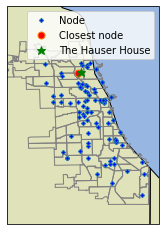

In [7]:
#Get to plotting! P.S.: Run this cell twice to make the image larger
#Upload a shapefile for the Chicagoland area. I found this on a Chicago governmental website; it's of Chicago community areas
#To use this shapefile you MUST upload ALL CONTENTS that came in the folder you downloaded to your Assignment_4 folder in Jupyter
reader = shpreader.Reader('geo_export_ba857900-5ffd-4245-b361-1a0a541e5078.shp')

#Create counties feature using Chicago data portal shapefiles
counties = list(reader.geometries())
COUNTIES = cf.ShapelyFeature(counties, ccrs.PlateCarree())

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cf.LAKES)
ax.add_feature(cf.STATES)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

#Plot all nodes, the closest node to you, and your house!
#Notice how we pulled on the function we made from the previous cell
plt.plot(lons, lats, 'D', linestyle='', markersize='3', markerfacecolor='b', label='Node')
plt.plot(lons[closest_node_index], lats[closest_node_index], 'o', linestyle='', markersize='7', markerfacecolor='r', label='Closest node')
plt.plot(my_house_lon, my_house_lat, '*', markersize='9', color='g', markerfacecolor='g', label='The Hauser House')

ax.set_extent([-87.85, -87.5, 41.6, 42.1])
plt.rcParams['figure.figsize']=15,15

plt.legend()
ax.stock_img()
plt.show()

Q5: What sensors are available in that node?

A: There are 20 different sensors available. See line 11 for specifics.

In [8]:
#Check out (print) the massive data.csv file...
#Put this in its own cell bc it takes forever!
data = pd.read_csv("/projects/b1045/AoT/AoT_reduced_data_10m/data.csv")

In [9]:
#Notice: what is different between the node_id column in the data.csv file compared to the node_id column in the node.csv file...
#What are the implications of this?

In [10]:
#Print only the rows where your node ID appears in the data.csv file
data.set_index('node_id', inplace=True)
print(data.loc['001e0610b9e5'])

new_data = data.loc['001e0610b9e5']

                        timestamp   subsystem           sensor      parameter  \
node_id                                                                         
001e0610b9e5  2018/05/10 10:35:00  lightsense          hih6130    temperature   
001e0610b9e5  2018/05/10 10:35:00  lightsense           tmp421    temperature   
001e0610b9e5  2018/05/10 10:35:00    metsense           bmp180    temperature   
001e0610b9e5  2018/05/10 10:35:00    metsense           htu21d    temperature   
001e0610b9e5  2018/05/10 10:35:00    metsense          pr103j2    temperature   
...                           ...         ...              ...            ...   
001e0610b9e5  2018/10/31 23:55:00   chemsense              no2  concentration   
001e0610b9e5  2018/10/31 23:55:00   chemsense               o3  concentration   
001e0610b9e5  2018/10/31 23:55:00   chemsense  oxidizing_gases  concentration   
001e0610b9e5  2018/10/31 23:55:00   chemsense   reducing_gases  concentration   
001e0610b9e5  2018/10/31 23:

In [11]:
#Print all sensor types that your node has without repeats
M_list = new_data.sensor.tolist()
M_array = np.array(M_list)
print(np.unique(M_array))
print(len(np.unique(M_array)))

['at0' 'at1' 'at2' 'at3' 'bmp180' 'co' 'h2s' 'hih6130' 'htu21d' 'lps25h'
 'no2' 'o3' 'oxidizing_gases' 'pr103j2' 'reducing_gases' 'sht25' 'so2'
 'tmp112' 'tmp421' 'tsys01']
20


Q6: What is the time period of the data availability of a sensor in that node?

A: Start date: 2018/05/01 00:05:00. End: 2018/10/31 23:55:00.

In [12]:
#For Question 6, we chose to work with the o3 sensor from our node
#Print only the rows where 'o3' appears in our node
new_data.set_index('sensor', inplace=True)
sensorone = np.array(new_data.loc['o3'])
sensorone = sensorone.tolist()
#For our sensor in our node there were two outlier points in the beginning of our dataset. We popped them off to remove them
sensorone.pop(0)
#Notice how what was the 'second one' is now the first, as the first has since been removed
sensorone.pop(0)
sensorone = pd.DataFrame(sensorone)
print(sensorone)

                        0          1              2       3   4      5
0     2018/10/18 16:35:00  chemsense  concentration   9.024   9  1.003
1     2018/10/18 16:45:00  chemsense  concentration   4.616  13  0.355
2     2018/10/18 16:55:00  chemsense  concentration   8.848  18  0.492
3     2018/10/18 17:05:00  chemsense  concentration   4.571  15  0.305
4     2018/10/18 17:15:00  chemsense  concentration   9.637  15  0.642
...                   ...        ...            ...     ...  ..    ...
1912  2018/10/31 23:15:00  chemsense  concentration   0.720  23  0.031
1913  2018/10/31 23:25:00  chemsense  concentration   3.565  24  0.149
1914  2018/10/31 23:35:00  chemsense  concentration  19.937  24  0.831
1915  2018/10/31 23:45:00  chemsense  concentration  22.527  24  0.939
1916  2018/10/31 23:55:00  chemsense  concentration  20.139  24  0.839

[1917 rows x 6 columns]


Q7: Plot a time series of any available sensor in the node closest to you.

A: See line 16.

In [13]:
#Our node had 45 values in the first day and 144 values for every day after that.
#For our data, we plotted an average of the first 45 values in column 6. From then on, every 144.
#You may want to create different for loops for your data.
first_value_list = []
for i in range(0,45):
    val = sensorone.iloc[i,5]
    first_value_list.append(val)
    first_value = sum(first_value_list)/len(first_value_list)
value_avg_list = []
value_avg_list.append(first_value)

#Y-coordinates list
last_column = sensorone.iloc[:, 5].tolist()
last_column = last_column[45:]
for i in range(0,13):
    daily_avg = sum(last_column[(144*i):(144*(i+1))])/144
    value_avg_list.append(daily_avg)

#X-coordinates list
x_list = []
for i in range(18, 32):
    date = f'2018-10-{i}'
    x_list.append(date)

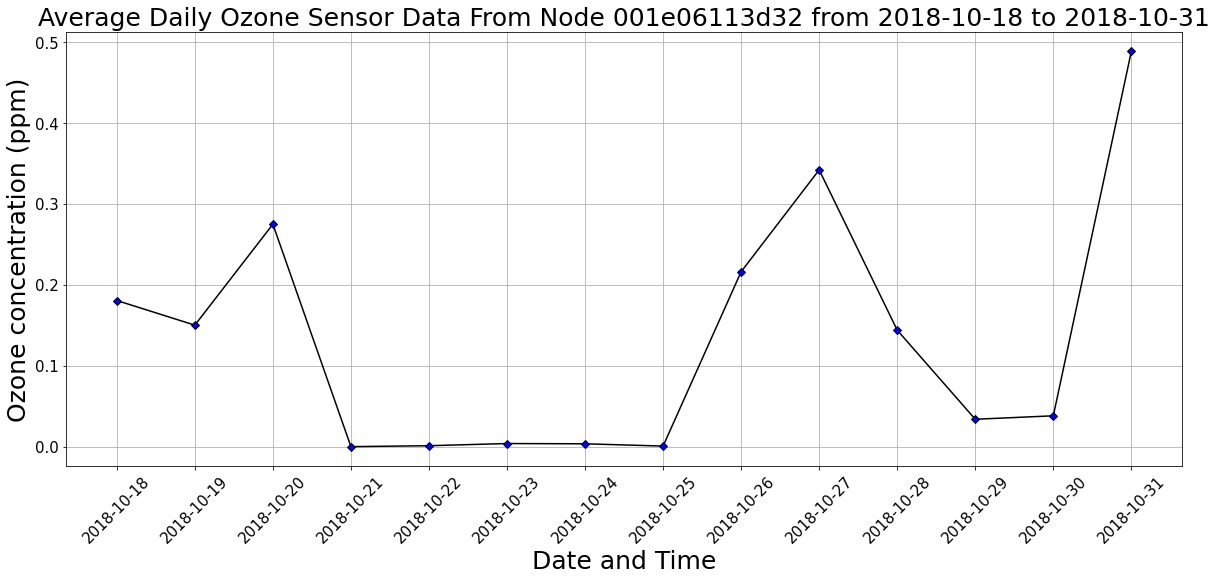

In [14]:
#Plot (this graph is of AVERAGE daily data)
plt.figure(figsize=(20, 8))
plt.plot(x_list, value_avg_list, 'D', markerfacecolor='b', linestyle='-', color='k')
plt.xlabel('Date and Time', fontsize=25)
plt.ylabel('Ozone concentration (ppm)', fontsize=25)
plt.title(f'Average Daily Ozone Sensor Data From Node {node_name} from {x_list[0]} to {x_list[-1]}', fontsize=25)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

plt.savefig('Time_series_Asg4.png')
plt.show()

Q8: Create a plot of 4 sensors.

A: See line 27.

Ok, this is where things get tricky...
We had to create a new Jupyter notebook in our Assignment 4 folder because my kernel would break every time we tried to load the data.csv file for a second time.

The 4 csv files below are from this second Jupyter notebook. These csv files have been trimmed down to only include what we need exactly to answer Question 8. Because of this, they are much smaller and our kernel can handle them.
See the Question_8 Jupyter notebook file.

In [15]:
#Upload the csv files from the second Jupyter notebook. Name them something tidy.
sensor_tmp = pd.read_csv('sensor_tmp421.csv')
sensor_bmp = pd.read_csv('sensor_bmp180.csv')
sensor_o3 = pd.read_csv('sensor_o3.csv')
sensor_current = pd.read_csv('sensor_current.csv')

In [16]:
#Redefine value names and specify the data such that there are no repeats of node IDs.
sensor_tmp = np.unique(sensor_tmp)
sensor_o3 = np.unique(sensor_o3)
sensor_bmp = np.unique(sensor_bmp)
sensor_current = np.unique(sensor_current)

In [17]:
#Convert to list form in order to iterate over in for loops
tmp_nodes = np.array(sensor_tmp).tolist()
bmp_nodes = np.array(sensor_bmp).tolist()
o3_nodes = np.array(sensor_o3).tolist()
current_nodes = np.array(sensor_current).tolist()

In [18]:
#These for loops are designed to grab the node coordinates corresponding to each sensor, from the lists created above
node = np.array(nodes).tolist()
tmp_coord = []
for i in tmp_nodes:
    for n in node:
        if i == n[0]:
            lat_lon = [n[4], n[5]]
            tmp_coord.append(lat_lon)
            
bmp_coord = []
for i in bmp_nodes:
    for n in node:
        if i == n[0]:
            lat_lon = [n[4], n[5]]
            bmp_coord.append(lat_lon)

o3_coord = []
for i in o3_nodes:
    for n in node:
        if i == n[0]:
            lat_lon = [n[4], n[5]]
            o3_coord.append(lat_lon)
            
current_coord = []
for i in current_nodes:
    for n in node:
        if i == n[0]:
            lat_lon = [n[4], n[5]]
            current_coord.append(lat_lon)
            
#Check it out!
print(tmp_coord)

[[41.916585999999995, -87.66640600000001], [41.954825, -87.645248], [41.994597, -87.655523], [41.96904, -87.659672], [41.751238, -87.71299], [41.722457, -87.57535], [41.891964, -87.611603], [41.852179, -87.675825], [41.878377, -87.627678], [41.881172, -87.686359], [41.810342, -87.590228], [41.736495, -87.614529], [41.768319, -87.683396], [41.857797, -87.685806], [41.736314, -87.624179], [41.75034, -87.66351800000001], [41.857959, -87.65642700000001], [41.961622, -87.665948], [41.736593, -87.604759], [41.880497, -87.74526800000001], [41.838618, -87.607817], [41.903335, -87.6674], [41.968757000000004, -87.679174], [41.965089, -87.679076], [41.751295, -87.605288], [41.882304, -87.671773], [41.788608, -87.598713], [41.923996, -87.761072], [41.880732, -87.72565999999999], [41.846897, -87.673061], [41.921405, -87.677766], [41.965256, -87.66672], [41.912681, -87.68105200000001], [41.846579, -87.68555699999999], [41.743814, -87.61473199999999], [41.857775, -87.66614399999999], [41.718008000000

In [19]:
#Make separate lists for latitude and longitude for each sensor
tmp_lat = [i[0] for i in tmp_coord]
tmp_lon = [i[1] for i in tmp_coord]

bmp_lat = [i[0] for i in bmp_coord]
bmp_lon = [i[1] for i in bmp_coord]

o3_lat = [i[0] for i in o3_coord]
o3_lon = [i[1] for i in o3_coord]

current_lat = [i[0] for i in current_coord]
current_lon = [i[1] for i in current_coord]

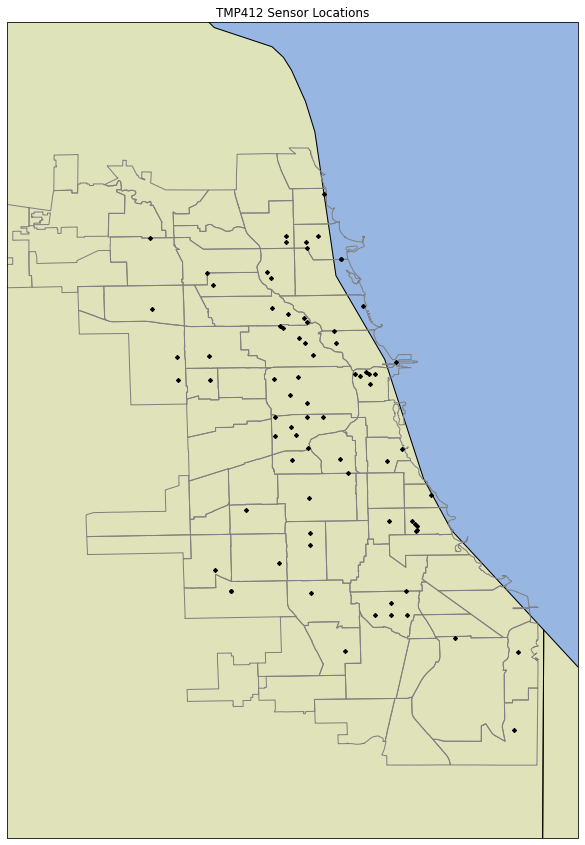

In [20]:
#Plot tmp data!
ax = plt.axes(projection=ccrs.PlateCarree())
plt.plot(tmp_lon, tmp_lat, 'D', linestyle='', markersize='3', color='k')
ax.add_feature(cf.LAKES)
ax.add_feature(cf.STATES)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
ax.set_extent([-87.85, -87.5, 41.6, 42.1])
plt.rcParams['figure.figsize']=7,7

plt.title('TMP412 Sensor Locations')
ax.stock_img()
plt.savefig('tmp.png')
plt.show()

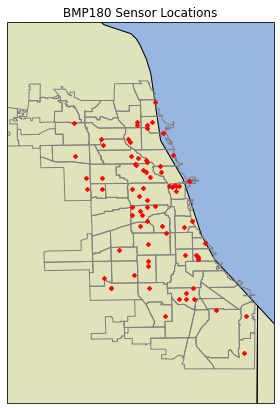

In [21]:
#Plot bmp data!
ax = plt.axes(projection=ccrs.PlateCarree())
plt.plot(bmp_lon, bmp_lat, 'D', linestyle='', markersize='3', color='r')
ax.add_feature(cf.LAKES)
ax.add_feature(cf.STATES)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
ax.set_extent([-87.85, -87.5, 41.6, 42.1])
plt.rcParams['figure.figsize']=7,7

plt.title('BMP180 Sensor Locations')
ax.stock_img()
plt.savefig('bmp.png')
plt.show()

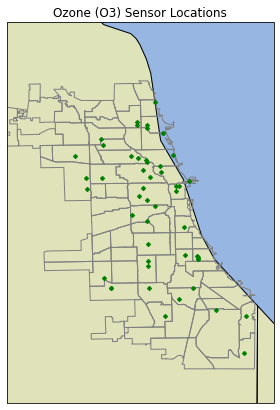

In [22]:
#Plot o3 data!
ax = plt.axes(projection=ccrs.PlateCarree())
plt.plot(o3_lon, o3_lat, 'D', linestyle='', markersize='3', color='g')
ax.add_feature(cf.LAKES)
ax.add_feature(cf.STATES)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
ax.set_extent([-87.85, -87.5, 41.6, 42.1])
plt.rcParams['figure.figsize']=7,7

plt.title('Ozone (O3) Sensor Locations')
ax.stock_img()
plt.savefig('o3.png')
plt.show()

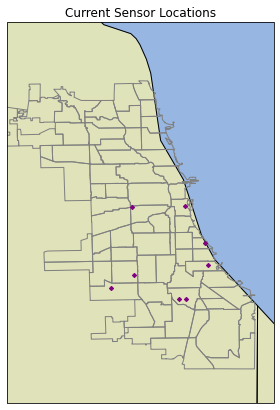

In [23]:
#Plot current data!
ax = plt.axes(projection=ccrs.PlateCarree())
plt.plot(current_lon, current_lat, 'D', linestyle='', markersize='3', color='purple')
ax.add_feature(cf.LAKES)
ax.add_feature(cf.STATES)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
ax.set_extent([-87.85, -87.5, 41.6, 42.1])
plt.rcParams['figure.figsize']=7,7

plt.title('Current Sensor Locations')
ax.stock_img()
plt.savefig('current.png')
plt.show()

In [24]:
#Image imports, exported at the end of each plot above when we saved the plot as a png file
img_tmp = mpimg.imread('tmp.png')
img_bmp = mpimg.imread('bmp.png')
img_o3 = mpimg.imread('o3.png')
img_current = mpimg.imread('current.png')

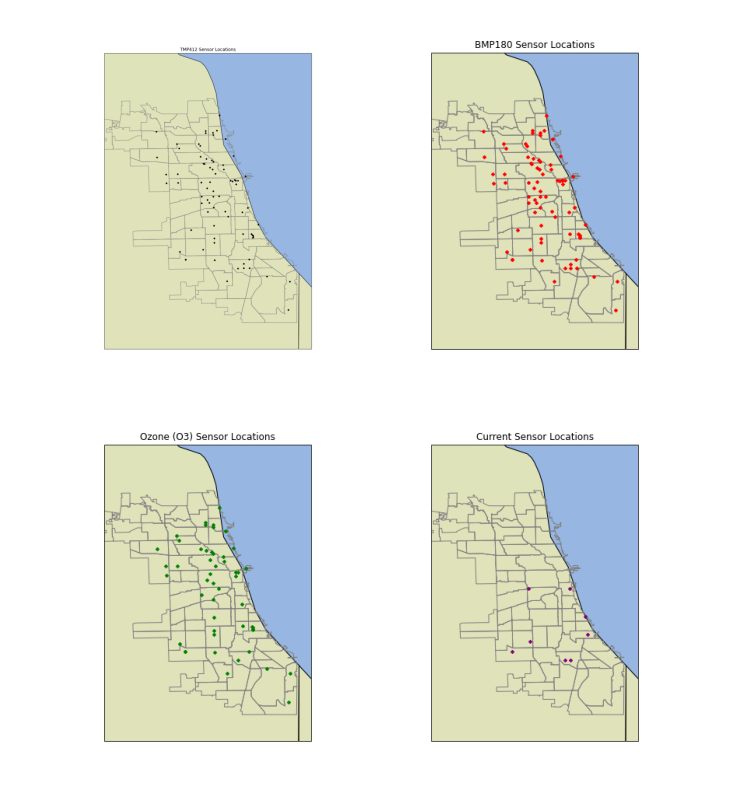

In [25]:
#Put all plots together into a neatly formatted subplot to facilitate comparisons
#We did this using matplotlib.image (see uploads at the beginning of assignment)
fig, ax = plt.subplots(2,2)
plt.tight_layout(pad=-15)
plt.subplots_adjust(hspace=.00001)

ax[0,0].imshow(img_tmp)
ax[0,0].axis('off')

ax[0,1].imshow(img_bmp)
ax[0,1].axis('off')

ax[1,0].imshow(img_o3)
ax[1,0].axis('off')

ax[1,1].imshow(img_current)
ax[1,1].axis('off')

plt.savefig('Asg4subplots.png')